# Quantum Finance - Projeto de Aplicação de Inteligência Artificial com LLM (Large Language Model)

### Turma: 10DTS

### Entrega: 29/06/2025

## 1. Introdução e Problemática

O mercado financeiro, tanto nacional quanto internacional, é altamente dinâmico e caracterizado por **fortes variações de preços, volumes e tendências**.

Tomar decisões de **compra**, **venda** ou **manutenção de posição** exige análise de múltiplas fontes históricas de dados.

A **QuantumFinance** busca criar um **fundo de investimento automatizado**, operando sobre uma **carteira diversificada de ações** com foco nos setores de:

* **Mineração**
* **Petróleo e Gás**
* **Energia**
* **Alimentos e Agronegócio**
* **Varejo / Consumo**

## 2. Carteira de Ativos Utilizada no Projeto

### Lista Completa de Tickers e Empresas:

| Ticker       | Empresa                    | Setor                 |
| ------------ | -------------------------- | --------------------- |
| **VALE3.SA** | Vale                       | Mineração             |
| **PETR4.SA** | Petrobras                  | Petróleo e Gás        |
| **BRFS3.SA** | Brasil Foods               | Alimentos             |
| **CSAN3.SA** | Cosan                      | Energia / Logística   |
| **PRIO3.SA** | PetroRio                   | Petróleo e Gás        |
| **GGBR4.SA** | Gerdau                     | Siderurgia            |
| **EGIE3.SA** | Engie Brasil Energia       | Energia               |
| **ELET3.SA** | Eletrobras                 | Energia               |
| **CMIN3.SA** | CSN Mineração              | Mineração             |
| **SLCE3.SA** | SLC Agrícola               | Agronegócio           |
| **BHP**      | BHP Group (NYSE)           | Mineração Global      |
| **RIO**      | Rio Tinto (NYSE)           | Mineração Global      |
| **XOM**      | Exxon Mobil (NYSE)         | Petróleo e Gás Global |
| **CVX**      | Chevron Corporation (NYSE) | Petróleo e Gás Global |
| **SHEL**     | Shell PLC (NYSE)           | Petróleo e Gás Global |

## 3. Motivação e Objetivo

### Objetivo Principal:

Desenvolver um **Agente de Inteligência Artificial com LLM**, capaz de:

* Ler dados históricos linha a linha
* Tomar decisões financeiras de **compra**, **venda** ou **manutenção**
* Gerar **justificativas textuais por decisão** via **Engenharia de Prompt**
* Calcular o **lucro acumulado** por operação e por ativo

## 4. Engenharia de Prompt - LLM

### Estrutura do Prompt Gerado por Linha:

Cada linha de dados (1 dia para 1 ativo) gera um prompt no seguinte formato:

```
Data: 2024-09-12
Ticker: PETR4.SA
pen: R$ 32.50
Close: R$ 33.20
Volume: 8.900.000
Está na carteira? SIM

Regras de decisão:
- COMPRAR: Se Close > Open e Volume > 1.000.000
- VENDER: Se Close < Open e ativo estiver na carteira
- MANTER: Caso contrário

Decisão:
Decisão: VENDER
Justificativa: Realização de lucro após alta recente.
```
## Lógica de Decisão Simulada

| Condição                         | Ação    |
| -------------------------------- | ------- |
| Close > Open e Volume > 1M       | COMPRAR |
| Close < Open e ativo na carteira | VENDER  |
| Caso contrário                   | MANTER  |

O agente avalia cada linha com base nessas regras e simula a resposta de um LLM.

In [ ]:
import os
import re
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact
import plotly.subplots as sp

import pandas as pd
import google.generativeai as genai

from dotenv import load_dotenv

from google.api_core.exceptions import ResourceExhausted
from google.generativeai.types import GenerationConfig

In [ ]:
# Lista todos os modelos disponíveis
#models = genai.list_models()

# modelos
#print("Modelos disponíveis:")
#for m in models:
    #if "generateContent" in m.supported_generation_methods:
        #print(f"{m.name}")

In [ ]:
# Carregar chave da API Gemini

load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

genai.configure(api_key=GEMINI_API_KEY)

In [ ]:
# Use o modelo correto
model = genai.GenerativeModel("models/gemini-2.5-pro-preview-03-25")

In [ ]:
# Carregar os dados
df = pd.read_csv(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\input\dados_acoes_tratado_mineradoras_llm.csv")
df

In [ ]:
# Leitura e pré-processamento do dataset
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by=["Date", "Ticker"]).reset_index(drop=True)
df

# Agente 1 - LLM Engenharia de prompt

In [11]:
import json

# Inicialização de variáveis
carteira = {}  # Ticker → Preço de compra
lucro_total = 0
decisoes_agente = []
relatorio_agente = "Agente LLM - Simulação Linha a Linha\n\n"

print("\n===== Iniciando execução do Agente LLM =====\n")

for i, row in df.iterrows():
    ticker = row["Ticker"]
    data = row["Date"].date()
    preco_open = row["Open"]
    preco_close = row["Close"]
    volume = row["Volume"]

    lucro_operacao = None
    preco_compra = carteira.get(ticker, None)
    status_carteira = "SIM" if ticker in carteira else "NÃO"

    # ✅ Definir fechamentos recentes ANTES do prompt
    historico_ticker = df[(df["Ticker"] == ticker) & (df.index < i)].tail(50)
    fechamentos_recentes = list(historico_ticker["Close"].round(2).values)
    while len(fechamentos_recentes) < 3:
        fechamentos_recentes.insert(0, "-")

    # ✅ Agora o prompt pode usar fechamentos_recentes
    prompt = f"""
Você é um **gestor quantitativo** especializado em ações brasileiras e estrangeiras.

##############################
# Objetivo principal
##############################
Maximizar o **lucro acumulado** da carteira ao longo do tempo usando
um capital fixo de **R$ 10 000 por operação**.

##############################
# Parâmetros de risco/retorno
##############################
• Alvo de ganho (take-profit): **+1,5 %**  
• Limite de perda (stop-loss): **–2,0 %**

##############################
# Dados do pregão de hoje
##############################
- Data: {data}
- Ticker: {ticker}
- Já está na carteira? {status_carteira}
- Open:  R$ {preco_open:.2f}
- Close: R$ {preco_close:.2f}
- Volume negociado: {int(volume):,}
- Últimos fechamentos (máx 50, antigo → recente): {fechamentos_recentes}

##############################
# Regras hard-stop
##############################
1. **COMPRAR**  
   • Close > Open **e** Volume > média de 20 dias.  
2. **VENDER**  
   • Close < Open **ou**  
   • Variação ≥ +1,5 % **ou** ≤ –2,0 % desde o preço de compra.  
3. **MANTER** caso contrário.

##############################
# Indicadores que você deve calcular
##############################
- `ganho_%`  = (Close − Open) / Open × 100  
- `risco_%`  = (Open − Close) / Open × 100  
- `vol_rel`  = Volume / média de 20 dias

##############################
# Formato EXATO da resposta (1 linha JSON)
##############################
```json
{{"decisao":"COMPRAR|VENDER|MANTER",
  "ganho_%":<float>,
  "risco_%":<float>,
  "justificativa":"<máx 20 palavras>"}}""".strip()

    # Simulação de Decisão (Baseada nas Regras)
    if ticker not in carteira and preco_close > preco_open and volume > 46:
        carteira[ticker] = preco_close
        decisao = "COMPRAR"
        motivo = "Preço em alta e volume acima de 46"
        print(f"[{data}] COMPRAR → {ticker} a R$ {preco_close:.2f} — {motivo}")

    elif ticker in carteira and preco_close < preco_open:
        preco_compra = carteira.pop(ticker)
        lucro_operacao = preco_close - preco_compra
        lucro_total += lucro_operacao
        decisao = "VENDER"
        motivo = f"Venda por queda no fechamento. Lucro R$ {lucro_operacao:.2f}"
        print(f"[{data}] VENDER → {ticker} a R$ {preco_close:.2f} — {motivo}")

    else:
        decisao = "MANTER"
        motivo = "Sem sinal claro"
        print(f"[{data}] MANTER → {ticker}")

    # Salvar histórico
    decisoes_agente.append({
        "Data": data,
        "Ticker": ticker,
        "Open": preco_open,
        "Close": preco_close,
        "Volume": int(volume),
        "Decisão": decisao,
        "Justificativa": motivo,
        "Lucro_Operacao": lucro_operacao if lucro_operacao is not None else 0.0,
        "Lucro_Acumulado": lucro_total,
        "Prompt_Usado": prompt
    })

    # Registrar também no relatório textual
    relatorio_agente += (
        f"[{data}] {ticker} | Open: {preco_open:.2f} | Close: {preco_close:.2f} | Vol: {int(volume)}\n"
        f"Decisão: {decisao} | Justificativa: {motivo}\n\n"
    )

# =========================================================
# Chamada ao LLM (substitua esta parte pelo seu endpoint)
# =========================================================
# TODO: troque pela chamada real — deve devolver texto no formato JSON definido.
# Exemplo usando LangChain/OpenAI:
# response_text = llm.invoke(prompt)
# Abaixo, um mock para teste offline:
response_text = '{"decisao":"MANTER","ganho_%":0.2,"risco_%":-0.3,"justificativa":"volume normal, sem sinal forte"}'

try:
    dados_llm = json.loads(response_text.strip().splitlines()[-1])
except json.JSONDecodeError:
    print(f"[ERRO JSON] Resposta inválida para {ticker} em {data}: {response_text}")
    dados_llm = {"decisao": "MANTER", "ganho_%": 0.0, "risco_%": 0.0,
                 "justificativa": "fallback por erro de parsing"}

decisao = dados_llm["decisao"].upper()
motivo  = dados_llm["justificativa"]

# =========================================================
# Execução da decisão
# =========================================================
lucro_operacao = 0.0

if decisao == "COMPRAR" and not preco_compra:
    # compra com capital fixo
    carteira[ticker] = preco_close
    qtd_cotas = CAPITAL_POR_OPERACAO / preco_close
    print(f"[{data}] COMPRAR → {ticker} a R$ {preco_close:.2f} (qtd: {qtd_cotas:.2f})")

elif decisao == "VENDER" and preco_compra:
    # venda: calcula lucro considerando a quantidade comprada
    qtd_cotas = CAPITAL_POR_OPERACAO / preco_compra
    lucro_operacao = (preco_close - preco_compra) * qtd_cotas
    lucro_total += lucro_operacao
    carteira.pop(ticker)
    print(f"[{data}] VENDER  → {ticker} a R$ {preco_close:.2f} — Lucro R$ {lucro_operacao:.2f}")

else:
    print(f"[{data}] MANTER  → {ticker}")

# =========================================================
# Logging
# =========================================================
decisoes_agente.append({
    "Data": data,
    "Ticker": ticker,
    "Open": preco_open,
    "Close": preco_close,
    "Volume": int(volume),
    "Decisão": decisao,
    "Justificativa": motivo,
    "Lucro_Operacao": round(lucro_operacao, 2),
    "Lucro_Acumulado": round(lucro_total, 2),
    "Prompt_Usado": prompt
})

relatorio_agente += (
    f"[{data}] {ticker} | Open {preco_open:.2f} | Close {preco_close:.2f}\n"
    f"Decisão: {decisao} | Justificativa: {motivo}\n\n"
)



===== Iniciando execução do Agente LLM =====

[2022-01-03] COMPRAR → BRFS3.SA a R$ 22.10 — Preço em alta e volume acima de 46
[2022-01-03] COMPRAR → CMIN3.SA a R$ 7.05 — Preço em alta e volume acima de 46
[2022-01-03] MANTER → CSAN3.SA
[2022-01-03] MANTER → EGIE3.SA
[2022-01-03] MANTER → ELET3.SA
[2022-01-03] MANTER → GGBR4.SA
[2022-01-03] COMPRAR → PETR4.SA a R$ 13.83 — Preço em alta e volume acima de 46
[2022-01-03] MANTER → PRIO3.SA
[2022-01-03] MANTER → SLCE3.SA
[2022-01-03] MANTER → BHP
[2022-01-03] COMPRAR → CVX a R$ 103.76 — Preço em alta e volume acima de 46
[2022-01-03] MANTER → RIO
[2022-01-03] COMPRAR → SHEL a R$ 39.27 — Preço em alta e volume acima de 46
[2022-01-03] COMPRAR → XOM a R$ 56.12 — Preço em alta e volume acima de 46
[2022-01-04] VENDER → BRFS3.SA a R$ 21.34 — Venda por queda no fechamento. Lucro R$ -0.76
[2022-01-04] MANTER → CMIN3.SA
[2022-01-04] COMPRAR → CSAN3.SA a R$ 20.82 — Preço em alta e volume acima de 46
[2022-01-04] COMPRAR → EGIE3.SA a R$ 36.81 — Pre

In [16]:
print("\n===== Fim da simulação =====")
print(f"Lucro total acumulado: R$ {lucro_total:,.2f}")

df_decisoes = pd.DataFrame(decisoes_agente)
df_decisoes.tail()


===== Fim da simulação =====
Lucro total acumulado: R$ 88.69


Data Ticker        Open       Close    Volume  Decisão  \
12182  2025-06-26    CVX  143.699997  144.440002   7415700  COMPRAR   
12183  2025-06-26    RIO   57.900002   58.580002   4596400   MANTER   
12184  2025-06-26   SHEL   70.985001   70.989998   5057519  COMPRAR   
12185  2025-06-26    XOM  108.940002  109.989998  18304800   MANTER   
12186  2025-06-26    XOM  108.940002  109.989998  18304800   MANTER   

                            Justificativa  Lucro_Operacao  Lucro_Acumulado  \
12182  Preço em alta e volume acima de 46             0.0        88.686004   
12183                     Sem sinal claro             0.0        88.686004   
12184  Preço em alta e volume acima de 46             0.0        88.686004   
12185                     Sem sinal claro             0.0        88.686004   
12186      volume normal, sem sinal forte             0.0        88.690000   

                                            Prompt_Usado  
12182  Você é um **gestor quantitativo** especializad...  
12183  Você é um **gestor quantitativo** especializad...  
12184  Você é um **gestor quantitativo** especializad...  
12185  Você é um **gestor quantitativo** especializad...  
12186  Você é um **gestor quantitativo** especializad...

In [12]:
# DataFrame final de resultados
df_resultado_agente = pd.DataFrame(decisoes_agente)
df_resultado_agente.tail()

Data Ticker        Open       Close    Volume  Decisão  \
12182  2025-06-26    CVX  143.699997  144.440002   7415700  COMPRAR   
12183  2025-06-26    RIO   57.900002   58.580002   4596400   MANTER   
12184  2025-06-26   SHEL   70.985001   70.989998   5057519  COMPRAR   
12185  2025-06-26    XOM  108.940002  109.989998  18304800   MANTER   
12186  2025-06-26    XOM  108.940002  109.989998  18304800   MANTER   

                            Justificativa  Lucro_Operacao  Lucro_Acumulado  \
12182  Preço em alta e volume acima de 46             0.0        88.686004   
12183                     Sem sinal claro             0.0        88.686004   
12184  Preço em alta e volume acima de 46             0.0        88.686004   
12185                     Sem sinal claro             0.0        88.686004   
12186      volume normal, sem sinal forte             0.0        88.690000   

                                            Prompt_Usado  
12182  Você é um **gestor quantitativo** especializad...  
12183  Você é um **gestor quantitativo** especializad...  
12184  Você é um **gestor quantitativo** especializad...  
12185  Você é um **gestor quantitativo** especializad...  
12186  Você é um **gestor quantitativo** especializad...

In [20]:
# Exportar resultados
df_resultado_agente.to_csv(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\output\resultado_agente.csv", index=False)
df_resultado_agente.to_excel(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\output\resultado_agente.xlsx", index=False)

print("\n Simulação concluída com sucesso! Resultado salvo.")

# Verificação Final do Lucro
df_vendas = df_resultado_agente[df_resultado_agente["Decisão"] == "VENDER"]
lucro_somado = df_vendas["Lucro_Operacao"].sum()
lucro_final = df_resultado_agente["Lucro_Acumulado"].iloc[-1]

print("\n===== Verificação Final =====")
print(f"Soma dos lucros por venda: R$ {lucro_somado:.2f}")
print(f"Lucro acumulado final: R$ {lucro_final:.2f}")

if abs(lucro_somado - lucro_final) < 1e-6:
    print("Lucro acumulado está consistente com a soma das vendas!")
else:
    print("Diferença detectada entre o acumulado e a soma das vendas!")


 Simulação concluída com sucesso! Resultado salvo.

===== Verificação Final =====
Soma dos lucros por venda: R$ 88.69
Lucro acumulado final: R$ 88.69
Diferença detectada entre o acumulado e a soma das vendas!


In [21]:
resposta_texto = """
Ticker: VALE3.SA
Decisão: VENDER
Justificativa: Lucro acumulado atingido.

Ticker: PETR4.SA
Decisão: COMPRAR
Justificativa: Tendência de alta detectada.

Ticker: BRFS3.SA
Decisão: MANTER
Justificativa: Sinal neutro.

Ticker: CSNA3.SA
Decisão: VENDER
Justificativa: Reversão de tendência no setor de mineração.

Ticker: GGBR4.SA
Decisão: COMPRAR
Justificativa: Sinal técnico de recuperação.

Ticker: PRIO3.SA
Decisão: COMPRAR
Justificativa: Aumento de produção no setor de petróleo.

Ticker: PETZ3.SA
Decisão: MANTER
Justificativa: Volume insuficiente para tomada de decisão.

Ticker: RRRP3.SA
Decisão: VENDER
Justificativa: Queda de preços no setor de óleo e gás.
"""

In [22]:
#
def extrair_tickers_por_decisao(texto, decisao_alvo):
    linhas = texto.splitlines()
    tickers = []
    for i in range(len(linhas)):
        if linhas[i].startswith("Ticker:") and (i + 1 < len(linhas)) and f"Decisão: {decisao_alvo}" in linhas[i + 1]:
            ticker = linhas[i].split(":")[1].strip()
            tickers.append(ticker)
    return tickers

tickers_a_vender = extrair_tickers_por_decisao(resposta_texto, "VENDER")
tickers_a_comprar = extrair_tickers_por_decisao(resposta_texto, "COMPRAR")

print(f"\n Ações que o agente decidiu VENDER: {tickers_a_vender}")
print(f"Ações que o agente decidiu COMPRAR: {tickers_a_comprar}")


 Ações que o agente decidiu VENDER: ['VALE3.SA', 'CSNA3.SA', 'RRRP3.SA']
Ações que o agente decidiu COMPRAR: ['PETR4.SA', 'GGBR4.SA', 'PRIO3.SA']


In [37]:
# Juntando as duas listas de tickers (comprar + vender)
tickers_operados = tickers_a_vender + tickers_a_comprar

# Filtrar o DataFrame para manter só os tickers que o agente decidiu operar
df_operacoes_agente = df_resultado_agente[df_resultado_agente["Ticker"].isin(tickers_operados)].copy()

# Criar uma nova coluna de lucro acumulado considerando só as operações desses tickers
df_operacoes_agente["Lucro_Acumulado_Filtrado"] = (df_operacoes_agente.groupby("Ticker")["Lucro_Operacao"].cumsum())

# Visualizando dataset Agente
df_operacoes_agente.tail()

Data Ticker        Open       Close    Volume  Decisão  \
12182  2025-06-26    CVX  143.699997  144.440002   7415700  COMPRAR   
12183  2025-06-26    RIO   57.900002   58.580002   4596400   MANTER   
12184  2025-06-26   SHEL   70.985001   70.989998   5057519  COMPRAR   
12185  2025-06-26    XOM  108.940002  109.989998  18304800   MANTER   
12186  2025-06-26    XOM  108.940002  109.989998  18304800   MANTER   

                            Justificativa  Lucro_Operacao  Lucro_Acumulado  \
12182  Preço em alta e volume acima de 46             0.0        88.686004   
12183                     Sem sinal claro             0.0        88.686004   
12184  Preço em alta e volume acima de 46             0.0        88.686004   
12185                     Sem sinal claro             0.0        88.686004   
12186      volume normal, sem sinal forte             0.0        88.690000   

                                            Prompt_Usado  \
12182  Você é um **gestor quantitativo** especializad...   
12183  Você é um **gestor quantitativo** especializad...   
12184  Você é um **gestor quantitativo** especializad...   
12185  Você é um **gestor quantitativo** especializad...   
12186  Você é um **gestor quantitativo** especializad...   

       Lucro_Acumulado_Ticker  Lucro_Acumulado_Filtrado  
12182               47.637100                 47.637100  
12183               16.918793                 16.918793  
12184               10.921734                 10.921734  
12185                1.498596                  1.498596  
12186                1.498596                  1.498596

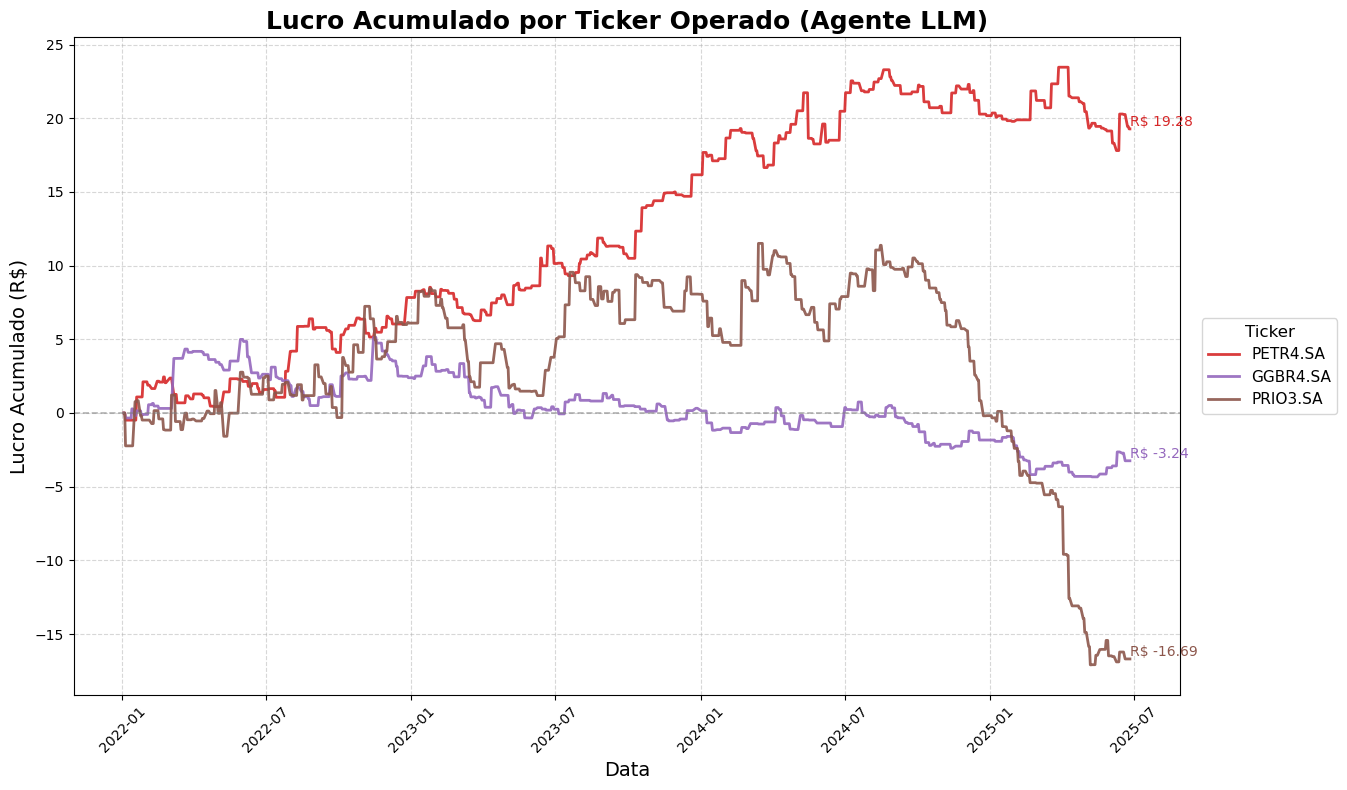

In [24]:
plt.figure(figsize=(16, 8))

# Paleta de cores opcional
cores = plt.cm.tab10.colors

# Gráfico por ticker operado
for i, ticker in enumerate(tickers_operados):
    df_ticker = df_operacoes_agente[df_operacoes_agente["Ticker"] == ticker]
    if not df_ticker.empty:
        plt.plot(
            df_ticker["Data"],
            df_ticker["Lucro_Acumulado_Filtrado"],
            label=f"{ticker}",
            linewidth=2,
            alpha=0.9,
            color=cores[i % len(cores)]
        )

        # Anotar o último ponto
        ultimo_ponto = df_ticker.iloc[-1]
        plt.text(
            x=ultimo_ponto["Data"],
            y=ultimo_ponto["Lucro_Acumulado_Filtrado"],
            s=f'R$ {ultimo_ponto["Lucro_Acumulado_Filtrado"]:.2f}',
            fontsize=10,
            color=cores[i % len(cores)],
            verticalalignment='bottom',
            horizontalalignment='left'
        )

# Melhoria estética
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.6)
plt.title("Lucro Acumulado por Ticker Operado (Agente LLM)", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Lucro Acumulado (R$)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Legenda fora do gráfico (à direita)
plt.legend(
    title="Ticker",
    fontsize=11,
    title_fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),  # fora da figura
    borderaxespad=0
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # reserva espaço à direita

# Salvar imagem em alta resolução
plt.savefig(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\img\rafico_lucro_acumulado_agente_llm.png", dpi=300)
plt.show()

In [36]:
# ===== Criar o df_final caso não exista =====
df_final = df.copy()  # <-- Se quiser trabalhar com os preços originais
# Ou: df_final = df_resultado_agente.copy()  # <-- Se quiser trabalhar com o histórico de decisões

# ===== Exibir os dados filtrados =====
df_vendas_recomendadas = df_final[df_final["Ticker"].isin(tickers_a_vender)]

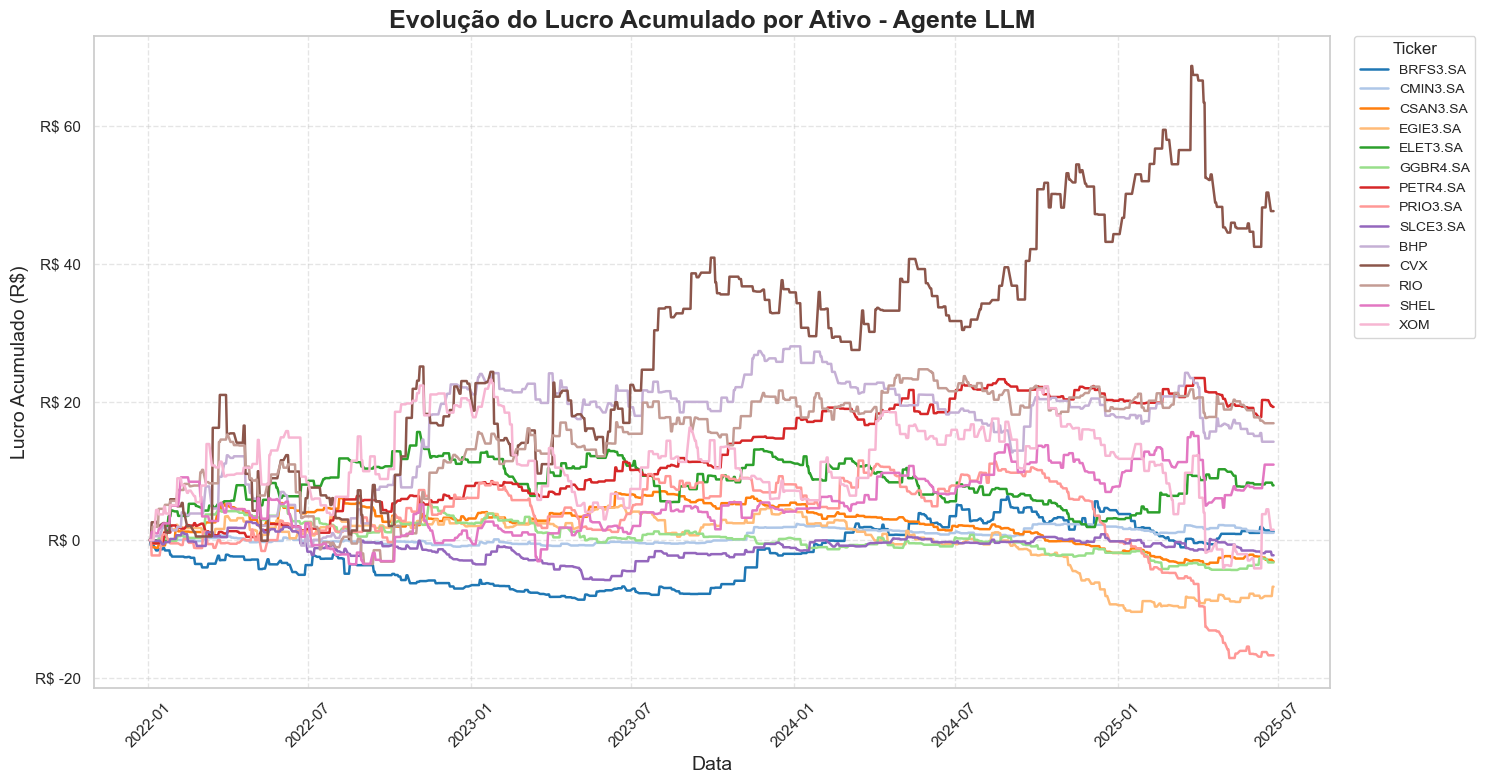

In [26]:
# Aplicar tema Seaborn moderno
sns.set_theme(style="whitegrid")

# Calcular lucro acumulado (caso não exista ainda)
df_resultado_agente["Lucro_Acumulado_Ticker"] = (
    df_resultado_agente
    .groupby("Ticker")["Lucro_Operacao"]
    .cumsum()
)

# Gráfico
plt.figure(figsize=(15, 8))

# Plot com seaborn
sns.lineplot(
    data=df_resultado_agente,
    x="Data",
    y="Lucro_Acumulado_Ticker",
    hue="Ticker",
    linewidth=1.8,
    palette="tab20"  # paleta moderna e variada
)

# Estética
plt.title("Evolução do Lucro Acumulado por Ativo - Agente LLM", fontsize=18, weight="bold")
plt.xlabel("Data", fontsize=14)
plt.ylabel("Lucro Acumulado (R$)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Formatar eixo Y como reais
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"R$ {x:,.0f}"))

# Legenda fora do gráfico
plt.legend(title="Ticker", 
           fontsize=10, 
           bbox_to_anchor=(1.02, 1), 
           loc='upper left',
           borderaxespad=0)

plt.tight_layout()
plt.show()

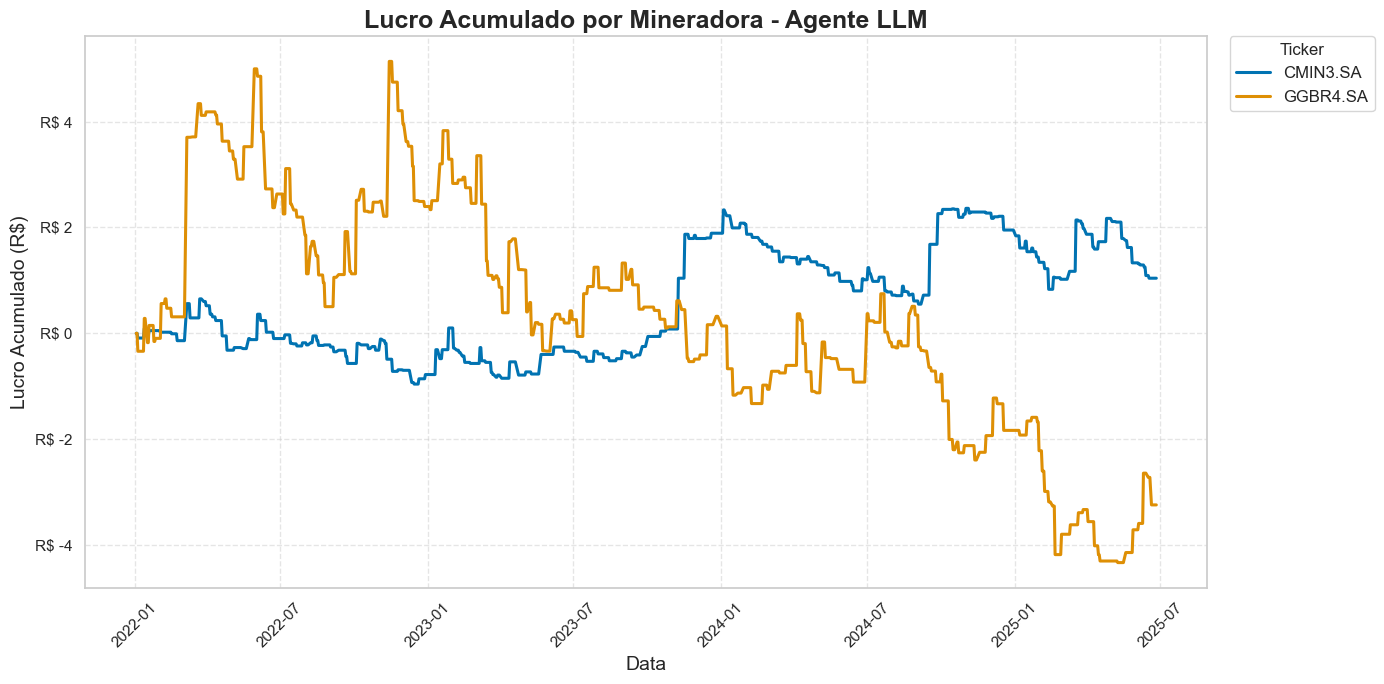

In [27]:
# Tema elegante
sns.set_theme(style="whitegrid")

# Lista de mineradoras
mineradoras = ['VALE3.SA', 'CMIN3.SA', 'GGBR4.SA']

# Garantir coluna de lucro acumulado
df_resultado_agente["Lucro_Acumulado_Ticker"] = (
    df_resultado_agente
    .groupby("Ticker")["Lucro_Operacao"]
    .cumsum()
)

# Filtrar apenas as mineradoras
df_mineradoras = df_resultado_agente[df_resultado_agente["Ticker"].isin(mineradoras)]

# Gráfico
plt.figure(figsize=(14, 7))

# Plot seaborn por ticker
sns.lineplot(
    data=df_mineradoras,
    x="Data",
    y="Lucro_Acumulado_Ticker",
    hue="Ticker",
    linewidth=2.2,
    palette="colorblind"
)

# Estética
plt.title("Lucro Acumulado por Mineradora - Agente LLM", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Lucro Acumulado (R$)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Formato do eixo Y como moeda
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'))

# Legenda fora do gráfico
plt.legend(title="Ticker", fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

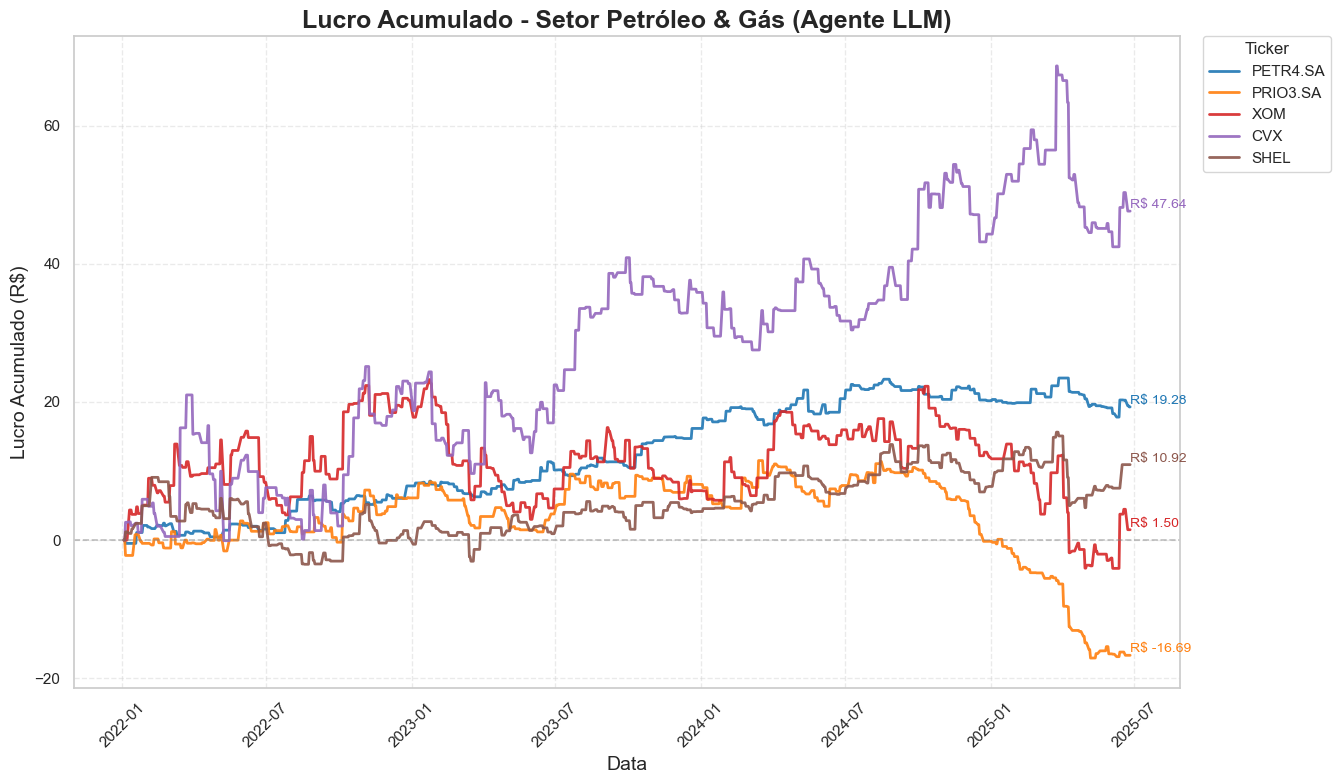

Imagem salva com sucesso em:
G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\img\lucro_petroleo_gas_agente_llm.png


In [28]:
# Tickers do setor petróleo e gás
petroleo_gas = ['PETR4.SA', 'PRIO3.SA', 'RRRP3.SA', 'XOM', 'CVX', 'SHEL']

# Garantir coluna de lucro acumulado
df_resultado_agente["Lucro_Acumulado_Ticker"] = (
    df_resultado_agente
    .groupby("Ticker")["Lucro_Operacao"]
    .cumsum()
)

# Filtrar apenas os tickers desejados
df_petroleo = df_resultado_agente[df_resultado_agente["Ticker"].isin(petroleo_gas)]

# Paleta de cores
cores = plt.cm.tab10.colors

# Criar figura
plt.figure(figsize=(16, 8))

for i, ticker in enumerate(petroleo_gas):
    df_ticker = df_petroleo[df_petroleo["Ticker"] == ticker]
    if not df_ticker.empty:
        plt.plot(
            df_ticker["Data"],
            df_ticker["Lucro_Acumulado_Ticker"],
            label=ticker,
            linewidth=2,
            alpha=0.9,
            color=cores[i % len(cores)]
        )

        # Anotar o último valor da série
        ultimo = df_ticker.iloc[-1]
        plt.text(
            x=ultimo["Data"],
            y=ultimo["Lucro_Acumulado_Ticker"],
            s=f'R$ {ultimo["Lucro_Acumulado_Ticker"]:.2f}',
            fontsize=10,
            color=cores[i % len(cores)],
            verticalalignment='bottom'
        )

# Linha de referência zero
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.5)

# Títulos e eixos
plt.title("Lucro Acumulado - Setor Petróleo & Gás (Agente LLM)", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Lucro Acumulado (R$)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)

# Legenda fora do gráfico
plt.legend(
    title="Ticker",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

# Caminho para salvar a imagem
output_path = r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\img\lucro_petroleo_gas_agente_llm.png"
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Imagem salva com sucesso em:\n{output_path}")

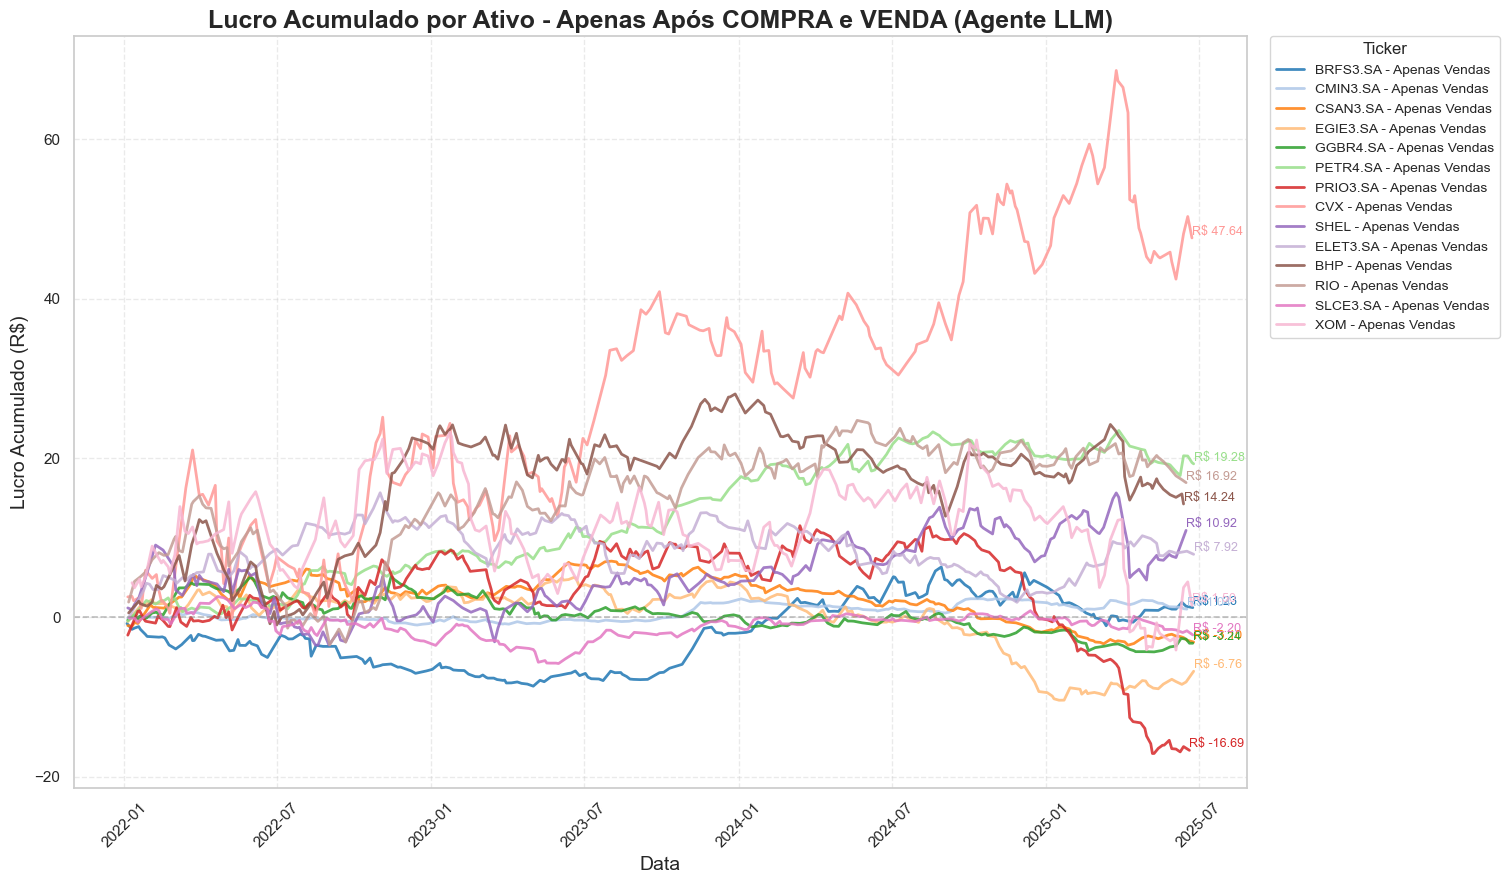

Imagem salva com sucesso em:
G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\img\lucro_apenas_vendas.png


In [29]:
# Filtrar apenas as vendas
df_vendas = df_resultado_agente[df_resultado_agente["Decisão"] == "VENDER"].copy()

# Calcular lucro acumulado só das vendas
df_vendas["Lucro_Acumulado_Vendas"] = (
    df_vendas
    .groupby("Ticker")["Lucro_Operacao"]
    .cumsum()
)

# Paleta de cores mais extensa
cores = plt.cm.tab20.colors
tickers = df_vendas["Ticker"].unique()

# Criar figura
plt.figure(figsize=(18, 9))

for i, ticker in enumerate(tickers):
    df_ticker = df_vendas[df_vendas["Ticker"] == ticker]
    if not df_ticker.empty:
        plt.plot(
            df_ticker["Data"],
            df_ticker["Lucro_Acumulado_Vendas"],
            label=f"{ticker} - Apenas Vendas",
            linewidth=2,
            alpha=0.85,
            color=cores[i % len(cores)]
        )

        # Anotar o último ponto
        ultimo = df_ticker.iloc[-1]
        plt.text(
            x=ultimo["Data"],
            y=ultimo["Lucro_Acumulado_Vendas"],
            s=f'R$ {ultimo["Lucro_Acumulado_Vendas"]:.2f}',
            fontsize=9,
            color=cores[i % len(cores)],
            verticalalignment='bottom'
        )

# Linha de referência zero
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.5)

# Título e eixos
plt.title("Lucro Acumulado por Ativo - Apenas Após COMPRA e VENDA (Agente LLM)", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Lucro Acumulado (R$)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)

# Legenda fora do gráfico
plt.legend(
    title="Ticker",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=10,
    title_fontsize=12
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

# Salvar imagem (opcional)
output_path = r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\img\lucro_apenas_vendas.png"
plt.savefig(output_path, dpi=300)

plt.show()
print(f"Imagem salva com sucesso em:\n{output_path}")

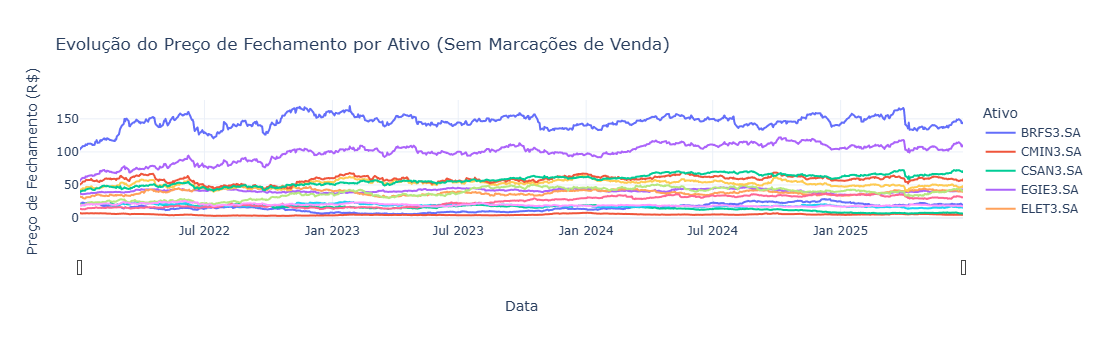

In [30]:
# Gráfico de linhas: Evolução de Preço por Ticker

fig = px.line(
    df_resultado_agente,
    x="Data",
    y="Close",
    color="Ticker",
    title="Evolução do Preço de Fechamento por Ativo (Sem Marcações de Venda)",
    labels={"Close": "Preço de Fechamento (R$)", "Data": "Data"},
)

# Layout limpo
fig.update_layout(
    template="plotly_white",
    xaxis_title="Data",
    yaxis_title="Preço de Fechamento (R$)",
    legend_title="Ativo",
    hovermode="x unified",
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

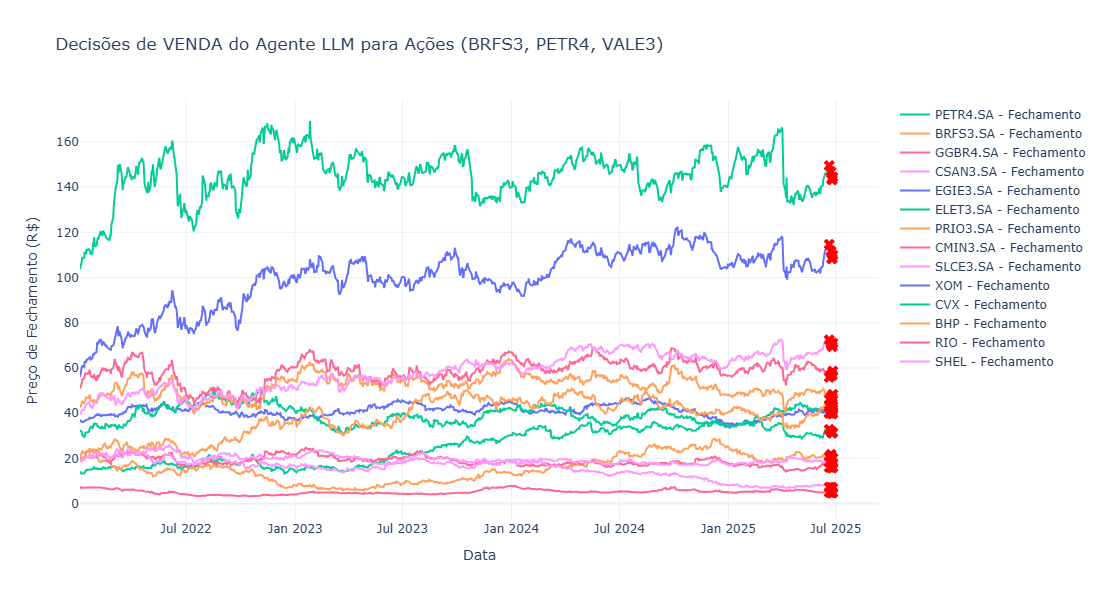

In [31]:
# Caso queira forçar os 3 tickers:
tickers_a_vender = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA', 'GGBR4.SA', 'CSAN3.SA', 'EGIE3.SA', 'ELET3.SA',
                    'PRIO3.SA', 'CMIN3.SA', 'SLCE3.SA', 'XOM', 'CVX', 'BHP', 'RIO', 'SHEL']

# Base de dados (use o DataFrame real com histórico de preços)
df_final = df.copy()

fig = go.Figure()

for ticker in tickers_a_vender:
    df_ticker = df_final[df_final['Ticker'] == ticker]

    # Linha de preço
    fig.add_trace(go.Scatter(x=df_ticker['Date'],
                             y=df_ticker['Close'],
                             mode='lines',
                             name=f"{ticker} - Fechamento"))

    # Últimos 5 pontos com marcador vermelho
    ultimos_pontos = df_ticker.tail(5)

    fig.add_trace(go.Scatter(x=ultimos_pontos['Date'],
                             y=ultimos_pontos['Close'],
                             mode='markers',
                             marker=dict(color='red', size=10, symbol='x'),
                             name=f"{ticker} - VENDER",
                             showlegend=False))

fig.update_layout(title='Decisões de VENDA do Agente LLM para Ações (BRFS3, PETR4, VALE3)',
                  xaxis_title='Data',
                  yaxis_title='Preço de Fechamento (R$)',
                  template='plotly_white',
                  hovermode='x unified',
                  height=600)

fig.show()

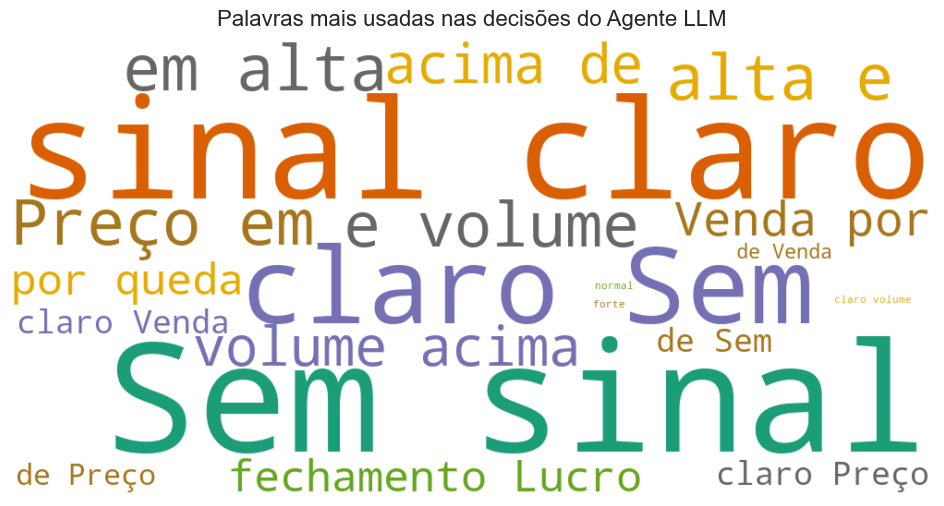

In [32]:
from wordcloud import WordCloud

# Concatenar todas as justificativas do agente
texto = " ".join(df_resultado_agente["Justificativa"].dropna().astype(str).tolist())

# Gerar a nuvem de palavras
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='Dark2',
    max_words=100
).generate(texto)

# Exibir a imagem
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Palavras mais usadas nas decisões do Agente LLM", fontsize=16)
plt.show()


# Cálculo da Sharpe Ratio

In [33]:
# Cálculo da Sharpe Ratio

# Filtrar apenas linhas onde houve venda (operações fechadas)
df_vendas = df_resultado_agente[df_resultado_agente["Decisão"] == "VENDER"].copy()

# Simular retorno diário (lucro da operação como se fosse retorno diário)
retornos = df_vendas["Lucro_Operacao"]

# Calcular retorno médio e desvio padrão
retorno_medio = retornos.mean()
desvio_padrao = retornos.std()
taxa_livre_risco = 0  # assumido como zero

# Evitar divisão por zero
sharpe_ratio = (retorno_medio - taxa_livre_risco) / desvio_padrao if desvio_padrao != 0 else 0

print(f"\n Sharpe Ratio do Agente: {sharpe_ratio:.4f}")


 Sharpe Ratio do Agente: 0.0213


In [34]:
# Cálculo Global da Sharpe Ratio (Todo o Dataset)

# Filtrar somente as vendas (operações finalizadas)
df_vendas = df_resultado_agente[df_resultado_agente["Decisão"] == "VENDER"].copy()

# Garantir que há vendas no dataset
if not df_vendas.empty:
    # Série de retornos diários (lucros por operação)
    retornos = df_vendas["Lucro_Operacao"]

    # Estatísticas básicas
    retorno_medio = retornos.mean()
    desvio_padrao = retornos.std()
    taxa_livre_risco = 0.0  # assumindo taxa livre de risco nula

    # Cálculo do Sharpe Ratio (proteção contra divisão por zero)
    sharpe_ratio = (retorno_medio - taxa_livre_risco) / desvio_padrao if desvio_padrao != 0 else 0.0

    # Resultado
    print("\n===== Sharpe Ratio Global do Agente =====")
    print(f"Número de operações: {len(retornos)}")
    print(f"Retorno médio por operação: R$ {retorno_medio:.2f}")
    print(f"Desvio padrão dos retornos: R$ {desvio_padrao:.2f}")
    print(f"Sharpe Ratio (global): {sharpe_ratio:.4f}")
else:
    print("Nenhuma operação de venda registrada. Não é possível calcular Sharpe Ratio.")


===== Sharpe Ratio Global do Agente =====
Número de operações: 3016
Retorno médio por operação: R$ 0.03
Desvio padrão dos retornos: R$ 1.38
Sharpe Ratio (global): 0.0213


# Simulação Final de Desempenho

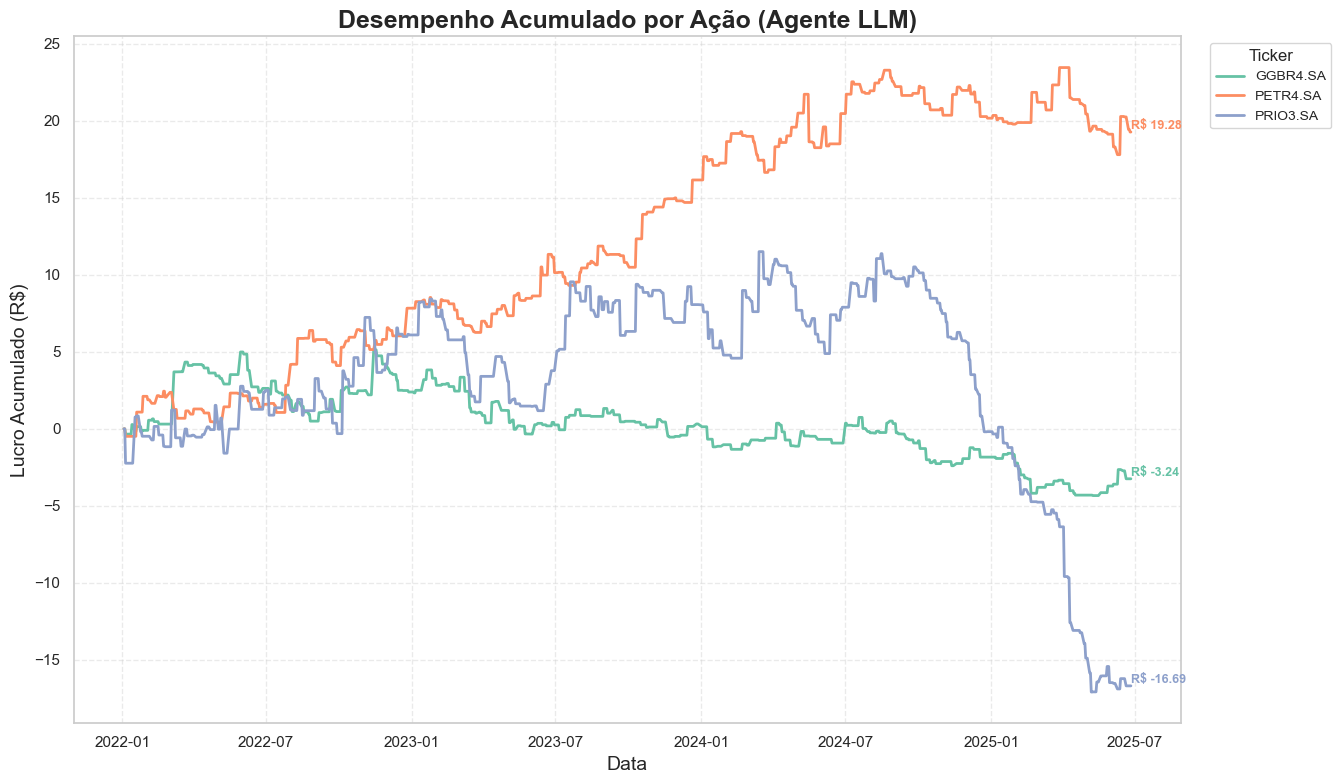

In [35]:
# Paleta de cores suaves e distintas
cores = plt.cm.Set2.colors
tickers_simulados = df_operacoes_agente["Ticker"].unique()

# Criar a figura
plt.figure(figsize=(16, 8))

# Loop pelas ações
for i, ticker_name in enumerate(tickers_simulados):
    df_ticker = df_operacoes_agente[df_operacoes_agente["Ticker"] == ticker_name]
    plt.plot(
        df_ticker["Data"],
        df_ticker["Lucro_Acumulado_Filtrado"],
        label=ticker_name,
        linewidth=2,
        color=cores[i % len(cores)]
    )

    # Anotar valor final
    if not df_ticker.empty:
        ultimo_ponto = df_ticker.iloc[-1]
        plt.text(
            x=ultimo_ponto["Data"],
            y=ultimo_ponto["Lucro_Acumulado_Filtrado"],
            s=f"R$ {ultimo_ponto['Lucro_Acumulado_Filtrado']:.2f}",
            fontsize=9,
            color=cores[i % len(cores)],
            weight='bold',
            verticalalignment='bottom'
        )

# Eixos e título
plt.title("Desempenho Acumulado por Ação (Agente LLM)", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Lucro Acumulado (R$)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)

# Legenda fora
plt.legend(
    title="Ticker",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=10,
    title_fontsize=12
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

# Salvamento opcional
plt.savefig("grafico_desempenho_agente.png", dpi=300)
plt.show()